## Métodos de Descomposición de Series de tiempo
---

Vamos a hacer un análisis Inicial a la serie de pasajeros. Un análisis similar deberá hacerse para las series ISE y ACC de la Base de datos Base_Accidentes.xlsx,

 Las primeras tres metodologías se basarán en el supuesto que una serie de tiempo observable puede ser descompuesta en una componente de  tendencia y una componente estacional, es decir, $\{X_{t}\}$ puede descomponerse de la siguiente forma aditiva
$$
X_{t}=m_{t}+S_{t}+Y_{t},
$$
donde $$m_{t}:\text{función que cambia suavemente,}$$\\
$$S_{t}:\text{función de periodo conocido d,}$$\\
$$Y_{t}:\text{ruido aleatorio estacionario en el sentido débil.}$$\\
Un modelo multiplicativo  puede ser considerado como modelo alternativo al aditivo,
$$
X_{t}=m_{t}\times S_{t} \times Y_{t}.
$$
Sin embargo es necesario primero hacer una transformación de Box-Cox para Estabilizar la varianza marginal.

 $$
 f_{\lambda}(u_{t})= 
 \lambda^{-1}(u^{\lambda}_{t}-1),   si \ u_{t} \geq 0, para\  \lambda>0
 $$
 o
 $$
 f_{\lambda}(u_{t})= \ln(u_{t}), \ si\  u_{t}>0, \ para\  \lambda=0
 $$

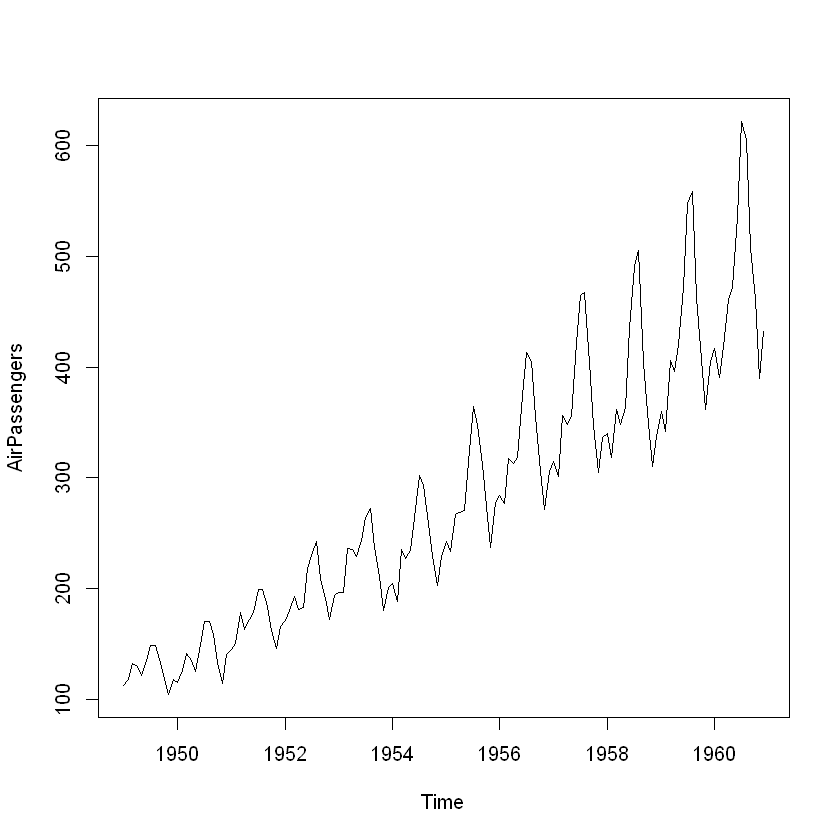

In [22]:
data("AirPassengers")
plot(AirPassengers)

[1] 4.102259e-05

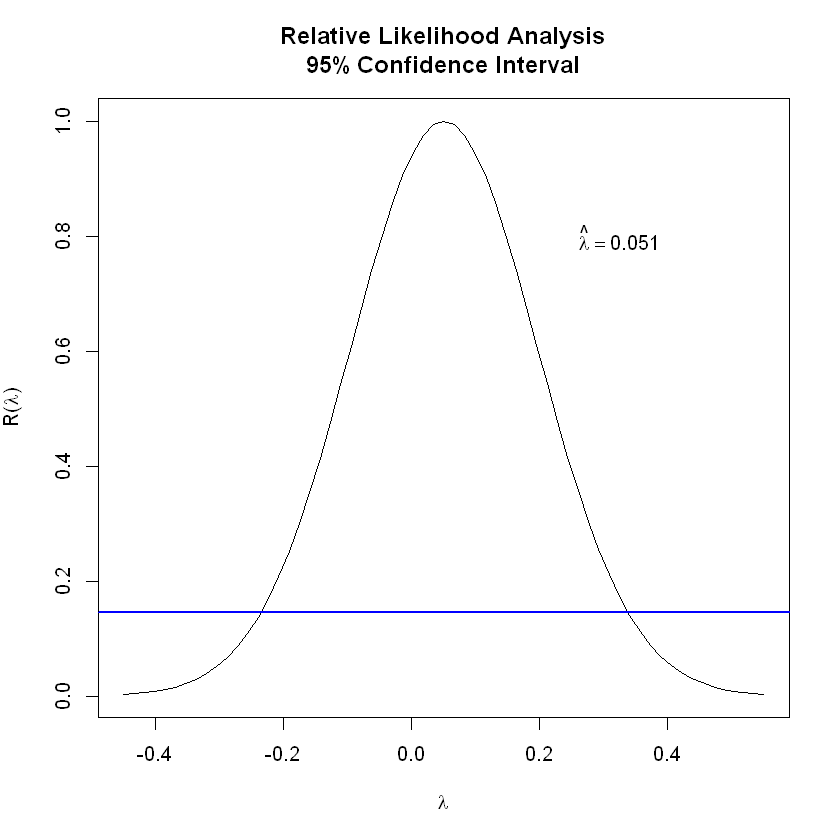

In [23]:
#####Transformación Box-Cox
library(FitAR)
library(forecast)
forecast::BoxCox.lambda(AirPassengers, method = "guerrero", lower = 0, upper = 2)  
##method="loglik"
FitAR::BoxCox(AirPassengers)

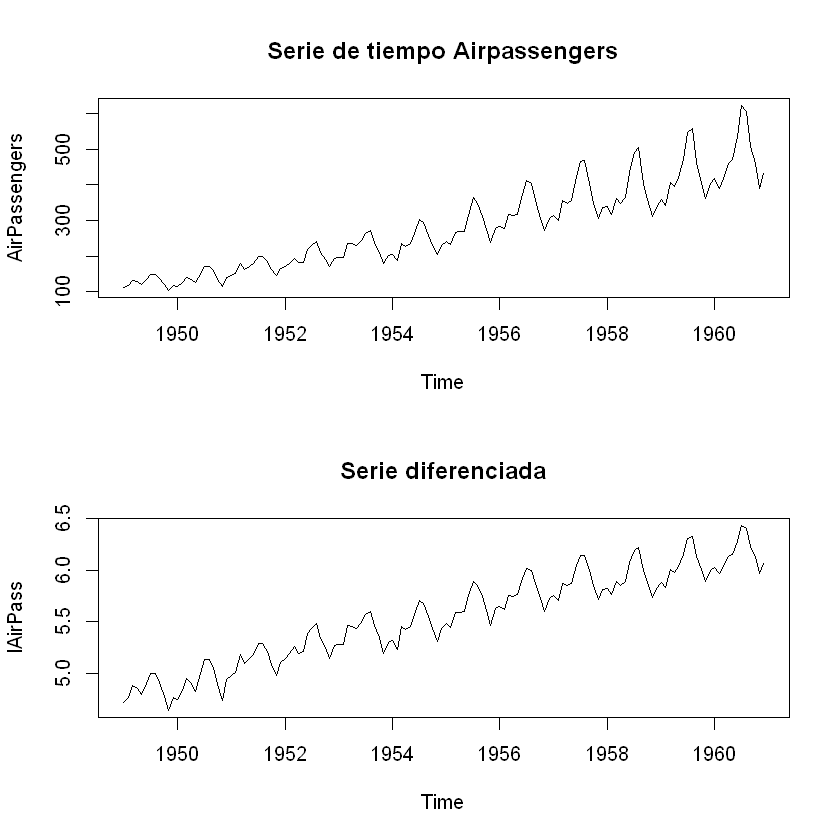

In [24]:
#air.arima<-arima(AirPassengers, c(0,1,1), seasonal=list(order=c(0,1,1), period=12))
#FitAR::BoxCox(air.arima)
lAirPass=log(AirPassengers)
par(mfrow=c(2,1))
plot(AirPassengers,main="Serie de tiempo Airpassengers")
plot(lAirPass, , main="Serie diferenciada")

---
# Descomposición usando promedios Móviles
## Para tendencia
---

Para considerar una descomposición por medio de filtros de promedios móviles, se tiene que dado q entero no negativo, 
el promedio móvil del proceso $\{ X_t\}$ a dos colas está determinado por:

$$
W_t = (2q+1)^{-1}\sum_{j=-q}^{q}X_{t-j}
$$

A continuación se presenta el filtro dado un $q=6$,l es claro aclarar quw por medio de la función *filter* de la libreria stats se crea el filtro el cual recibe la serie transformada. Cabe decir que este tipo de filtro no estima los primeros 6 y últimos 6 valores. (véase lAirPass.trend)

In [25]:
fltr <- c(1/2, rep(1, times = 11), 1/2)/12 ;fltr   ##q=6
## Estimación de la tendencia
lAirPass.trend <- stats::filter(lAirPass, filter = fltr, method = "convo", sides = 2)

[1] 0.04166667 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
 [7] 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333 0.08333333
[13] 0.04166667

La gráfica de la estimación de la tendencia esta determinada por:

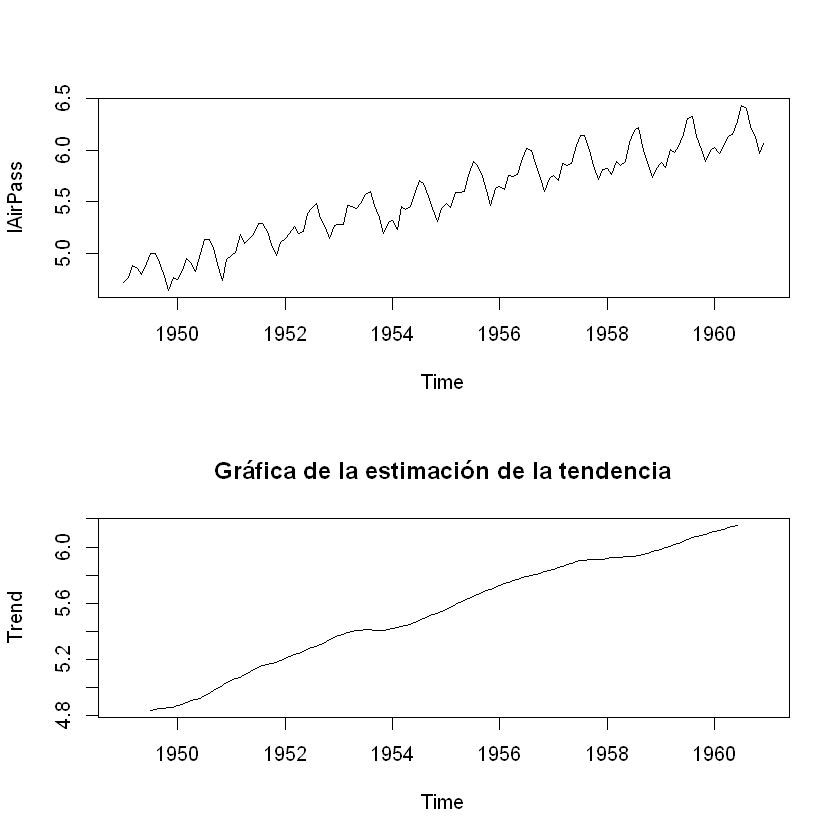

In [26]:
## Gráfica de la tendencia
#x11()
par(mfrow=c(2,1))
plot(lAirPass)
plot.ts(lAirPass.trend, ylab = "Trend", cex = 1,main="Gráfica de la estimación de la tendencia")

Otra forma de de hacer esta estimación de promedios móviles puede seer realizada por la función *decompose*.

---
# Efecto estacional a través del tiempo
---

Otra característica importante a destacar es la componente estacional, en la presente serie *Airpassengers* se presenta un ciclo anual, lo cual especifica que cada año se repiten los ciclos y valles. $d=12$

$$
\widehat{S}_k = w_k-d^{-1}\sum_{j=1}^{d}w_j  \;\;\;\;\;\;\;\;k=1,...,d
$$

A continuación quitamos de la serie la estimación de la componente estacional:

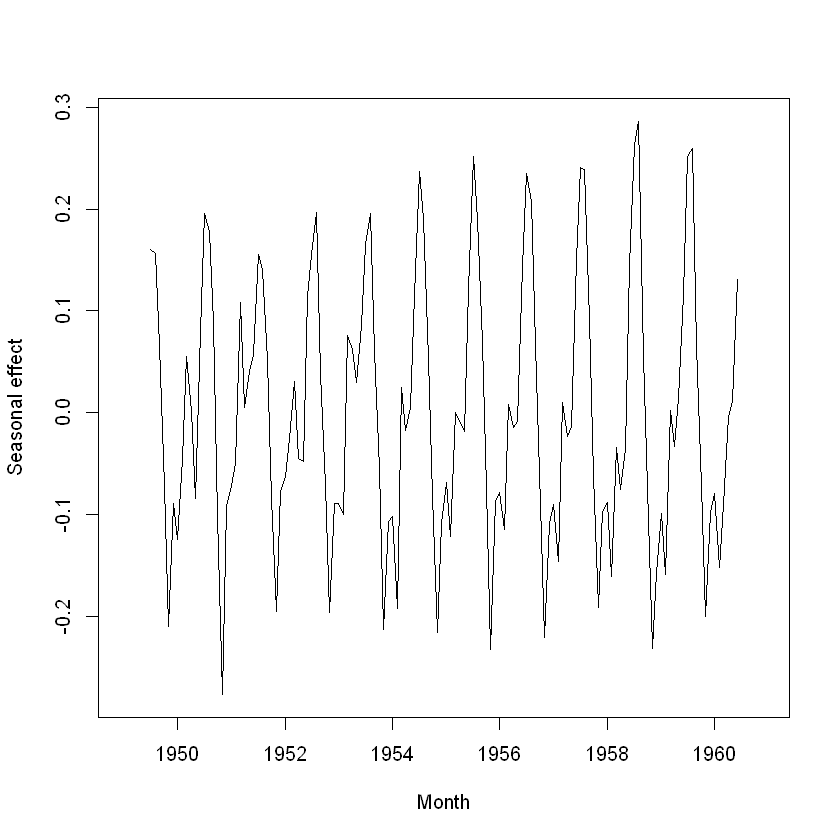

In [27]:
lAirPass.1T <- lAirPass - lAirPass.trend

## plot the monthly seasonal effects
plot.ts(lAirPass.1T, ylab = "Seasonal effect", xlab = "Month", cex = 1)

## length of ts
ll <- length(lAirPass.1T)

## frequency (ie, 12)
ff <- frequency(lAirPass.1T)
## number of periods (years); %/% is integer division
periods <- ll%/%ff


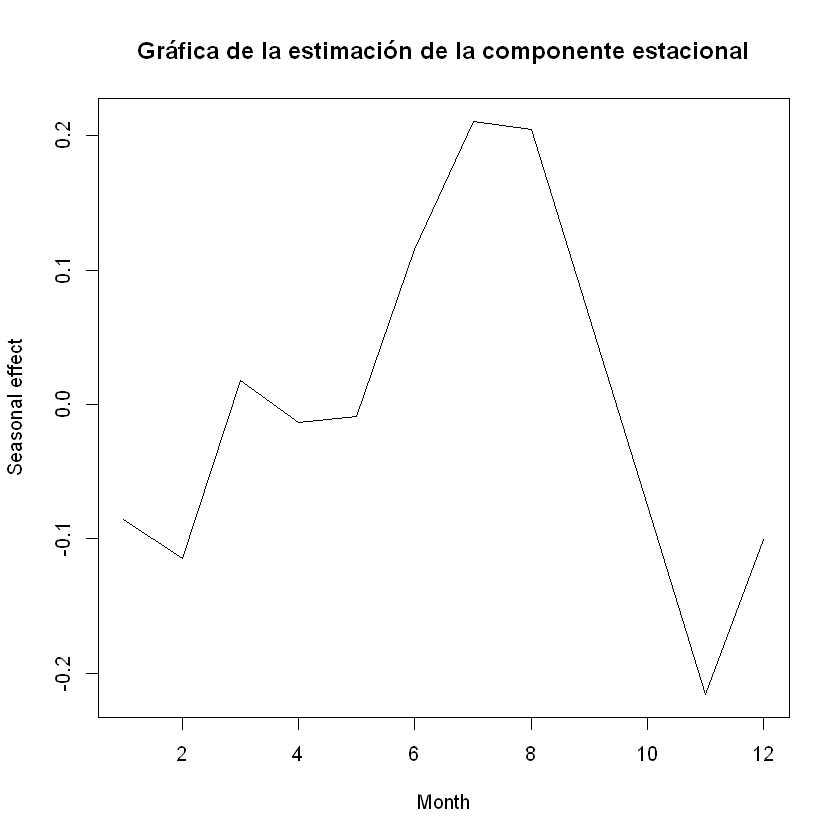

In [28]:
## index of cumulative month
index <- seq(1, ll, by = ff) - 1

## get mean by month
mm <- numeric(ff)
for (i in 1:ff) {
  mm[i] <- mean(lAirPass.1T[index + i], na.rm = TRUE)
}

## subtract mean to make overall mean=0
mm <- mm - mean(mm)

## plot the monthly seasonal effects
plot.ts(mm, ylab = "Seasonal effect", xlab = "Month", cex = 1,main="Gráfica de la estimación de la componente estacional")


Para quitar la componente de tendencia y componente estacional, se tiene:

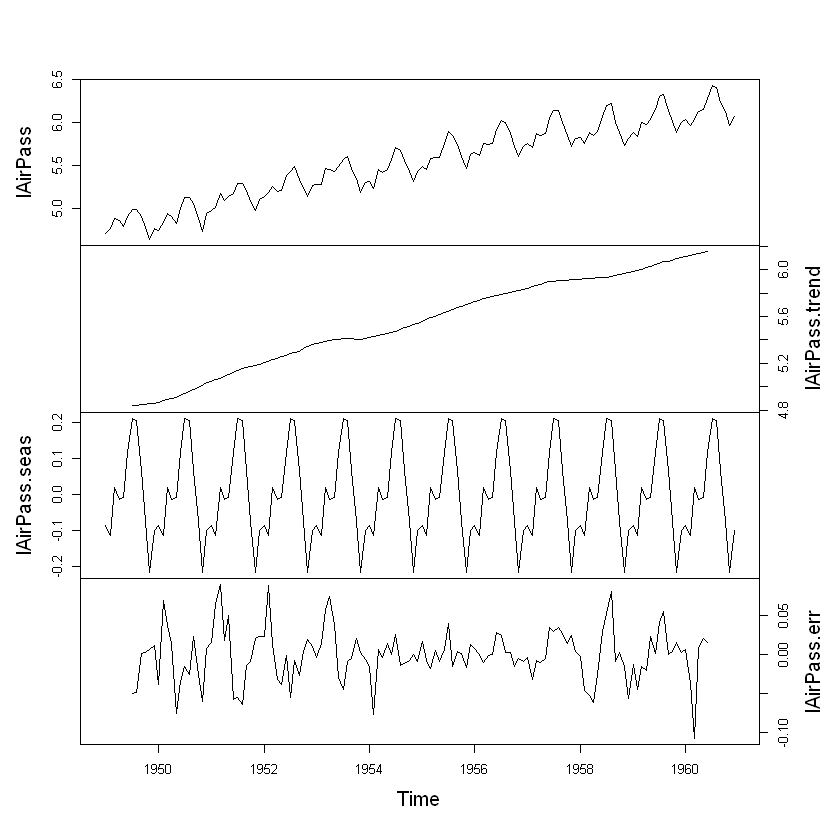

In [29]:
## create ts object for season
lAirPass.seas <- ts(rep(mm, periods + 1)[seq(ll)], start = start(lAirPass.1T), 
               frequency = ff)

## random errors over time
lAirPass.err <- lAirPass - lAirPass.trend - lAirPass.seas

## plot the obs ts, trend & seasonal effect
plot(cbind(lAirPass, lAirPass.trend, lAirPass.seas, lAirPass.err), main = "", yax.flip = TRUE)

---
# Dos funciones que hacen la descomposición de forma interna y automática
Una función específica para filtros de promedios móviles también puede ser usada y es **ma** del paquete *forecast*, donde order=d, note que hay una ligera diferencia por el 1/2 de los datos en los extremos

In [30]:
AirPass.trendma=forecast::ma(lAirPass,order=13)
#lAirPass.trendma-lAirPass.trend

####Uso de la función decompose
deslAirPass=decompose(lAirPass)
deslAirPass

$x
          Jan      Feb      Mar      Apr      May      Jun      Jul      Aug
1949 4.718499 4.770685 4.882802 4.859812 4.795791 4.905275 4.997212 4.997212
1950 4.744932 4.836282 4.948760 4.905275 4.828314 5.003946 5.135798 5.135798
1951 4.976734 5.010635 5.181784 5.093750 5.147494 5.181784 5.293305 5.293305
1952 5.141664 5.192957 5.262690 5.198497 5.209486 5.384495 5.438079 5.488938
1953 5.278115 5.278115 5.463832 5.459586 5.433722 5.493061 5.575949 5.605802
1954 5.318120 5.236442 5.459586 5.424950 5.455321 5.575949 5.710427 5.680173
1955 5.488938 5.451038 5.587249 5.594711 5.598422 5.752573 5.897154 5.849325
1956 5.648974 5.624018 5.758902 5.746203 5.762051 5.924256 6.023448 6.003887
1957 5.752573 5.707110 5.874931 5.852202 5.872118 6.045005 6.142037 6.146329
1958 5.828946 5.762051 5.891644 5.852202 5.894403 6.075346 6.196444 6.224558
1959 5.886104 5.834811 6.006353 5.981414 6.040255 6.156979 6.306275 6.326149
1960 6.033086 5.968708 6.037871 6.133398 6.156979 6.282267 6.432940 6.406

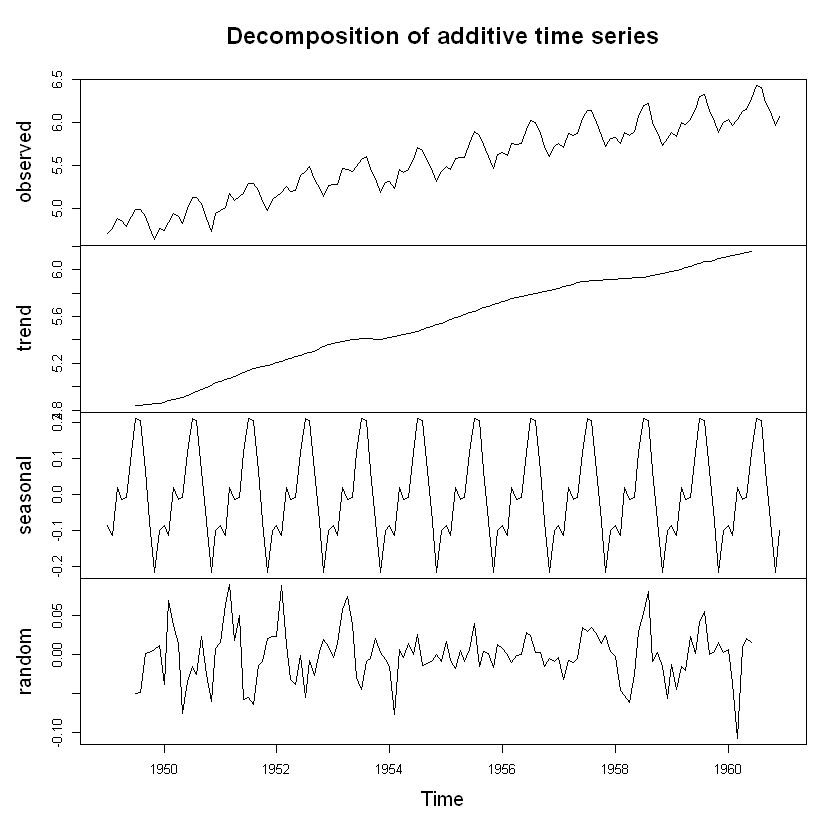

In [31]:
plot(deslAirPass)

---
# Otras ténicas de descomposición
---
Existe mas formas de hacer de descomposición de series de tiempo, por ejemplo está descomposción X11 usando el paquete **seasonal**, cuyo argumento teórico se puede ver el libro Seasonal Adjustment Methods and Real Time Trend-Cycle Estimation (Statistics for Social and Behavioral Sciences)
Estela Bee Dagum, Silvia Bianconcini.

In [32]:
library(seasonal)
library(ggplot2)
library(fpp)

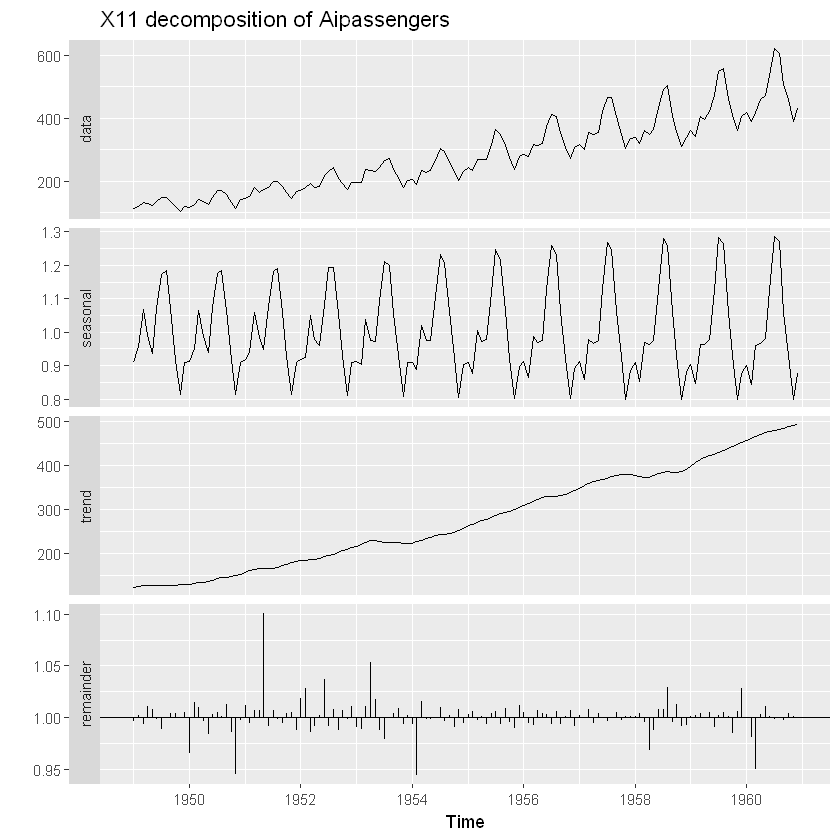

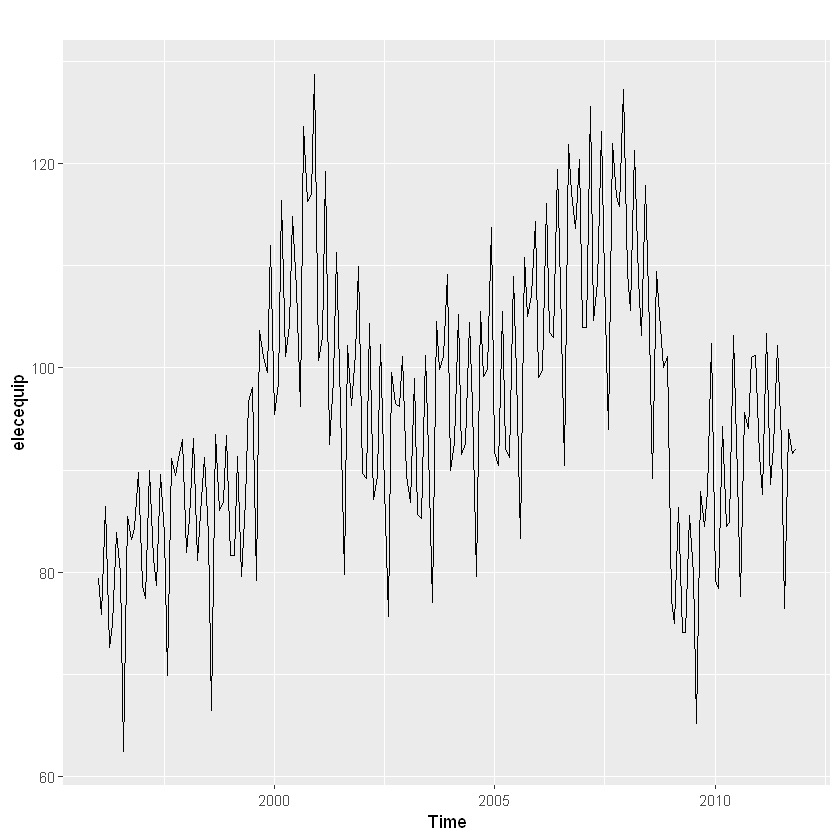

In [33]:
AirPassengers %>% seas(x11="") -> fit  #%>% Operador Pipe
autoplot(fit) + ggtitle("X11 decomposition of Aipassengers")
data(elecequip)
autoplot(elecequip)

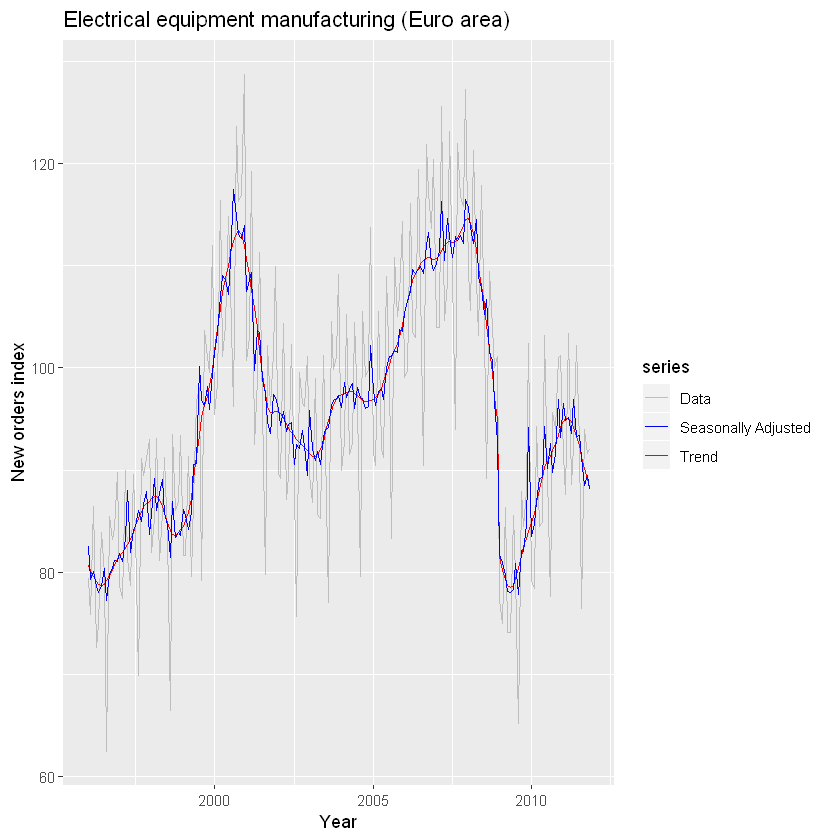

In [34]:
elecequip %>% seas(x11="") -> fit
autoplot(elecequip, series="Data") +
  autolayer(trendcycle(fit), series="Trend") +
  autolayer(seasadj(fit), series="Seasonally Adjusted") +
  xlab("Year") + ylab("New orders index") +
  ggtitle("Electrical equipment manufacturing (Euro area)") +
  scale_colour_manual(values=c("gray","blue","red"),
                      breaks=c("Data","Seasonally Adjusted","Trend"))

---
# Descomposición STL
---

El siguiente conjunto de datos mensual **elecequip** del paquete *fpp* hace referencia a la manufactura de componentes eléctricos (computadores y productos opticos de la zona Euro).

In [35]:
library(dplyr)
library(fpp)
?elecequip
# ?stl

La función **stl** es para realizar descomposición estacional de la serie de tiempo usando **lowess**, t.window=13 hace referencia al valor q y poder establecer análisis en un intervalo específico. Al colocar  *s.window="periodic"*  se asume tendencia periódica para la extracción de la tendencia estacional, automaticamente tomará *t.window=13*, además se puede colocar *degree* como el grado del polinomio.

El procedimiento dará menos ponderaciones a valores extremos.

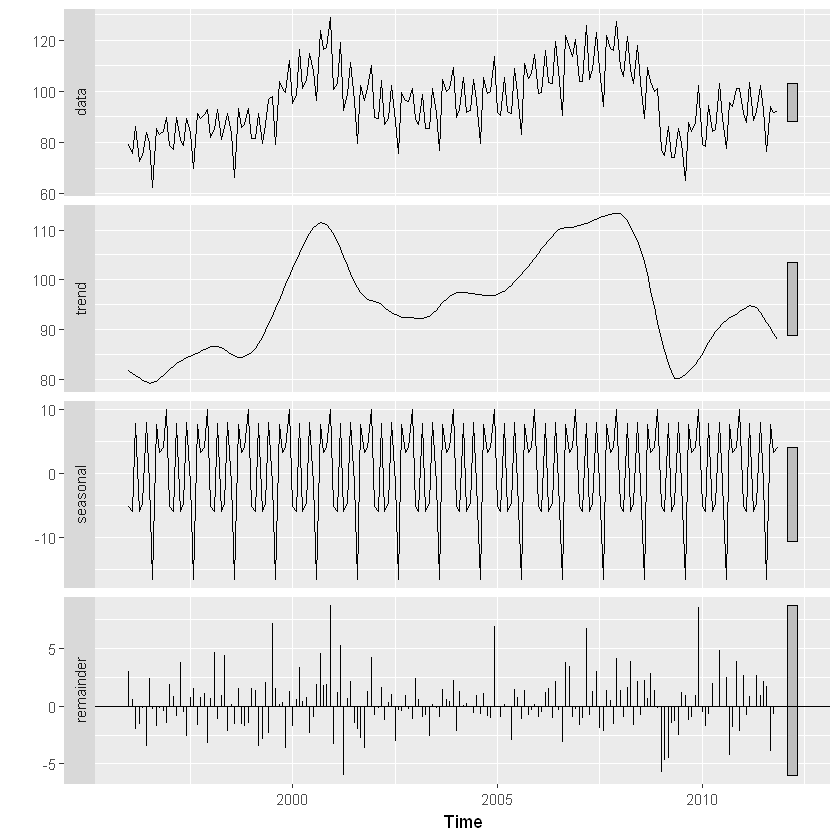

In [36]:
###La base de datos "elecequip" está en en el paquete fpp
###Note que el operador %>% pipe permite concatenar múltiples dplyr operaciones
###Manufacture of electrical equipment: computer, electronic and optical products
elecequip %>%
  stats::stl(t.window=13, s.window="periodic", robust=TRUE) %>%
  autoplot()

Se logra evidenciar que le serie ti4ne una tendencia (los valores medios no son iguales a lo largo del tiempo), además se evidencia una varianza marginal es constante al tener picos de igual longitud. Igualmente e logra ver una estacionalidad presente en los datos.

---
# Pronóstico basados en descomposición
---

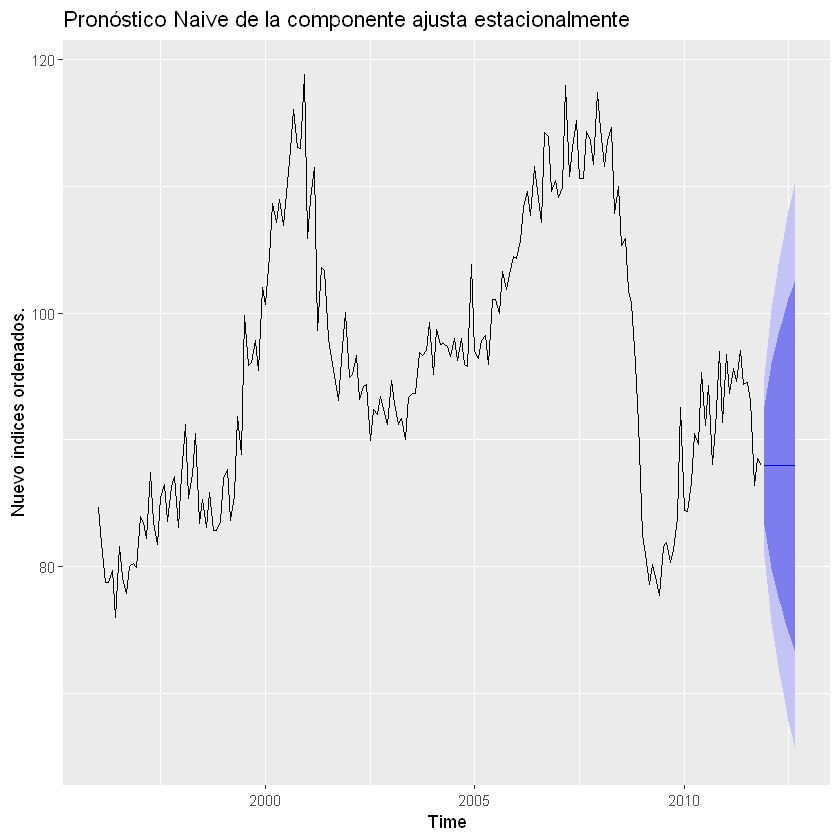

In [37]:
#Aqui se guarda el sesumen del ajuste a la tendencia y estacionalidad
fit <- stl(elecequip, t.window=13, s.window="periodic", robust=TRUE)
fit %>% seasadj() %>% naive() %>%
  autoplot() + ylab("Nuevo índices ordenados.") +
  ggtitle("Pronóstico Naive de la componente ajusta estacionalmente")

**Problema!!**

Esta técnica **STL** se queda un poco corta para hacer pronósticos de series de tiempo, esto es debido a que está diseñada específicamente para hacer interpolación. 


**Solución**:

Ahora una estrategia para poder hacer pronosticos de la tendencia $\widehat{m}_t$ es por medio del método **naive** (método ingenuo) el cual asume que la tendencia es una caminata aleatoria, $m_t = m_{t-1}+e_t$, predicciones basadas en el último valor que se observó.

En consecuencia a la anterior serie que muestra como pronosticos de la componente estacional una recta,  le adicionamos *la componente estacional* (a la linea de la gráfica anterior le adicionamos la tendencia)...**Pronósticos + random walk**

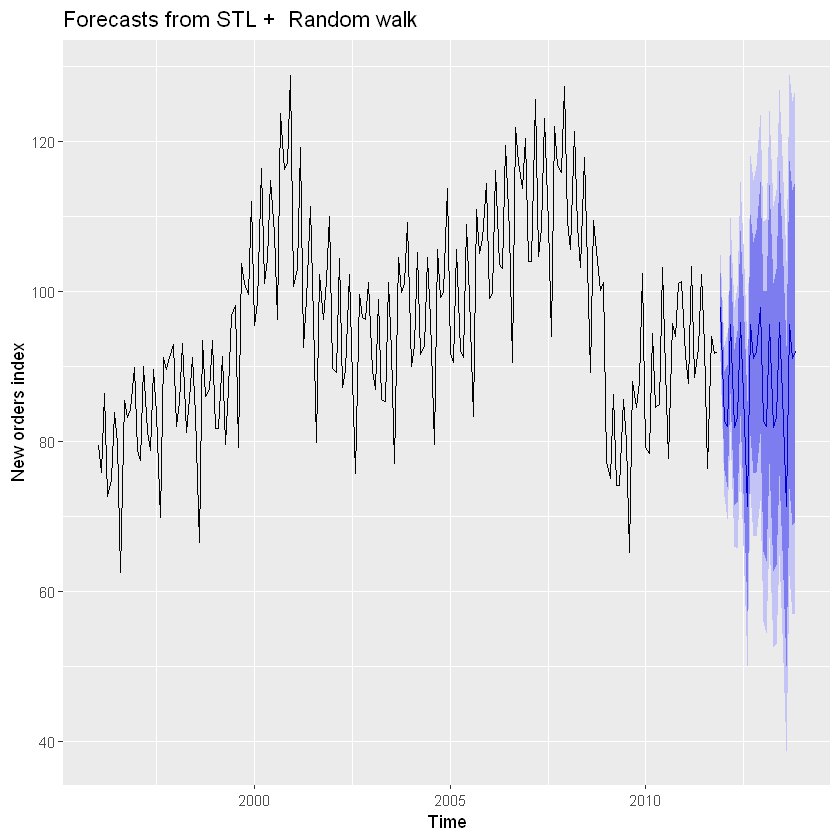

In [38]:
###El método naive consiste en que la predicción es el último valor real de la serie(o el de una caminata aleatoria).
#Ahora se re-estacionalizan los datos añadiendo 
###Los pronósticos de la componente estacional.
fit %>% forecast(method="naive") %>%
  autoplot() + ylab("New orders index")

###Note que la obtención de los pronósticos  es obtenida paso a paso.
###Otra forma de hacerlo es usando la función stlf
fcast1 <- stlf(elecequip, method='naive')  #ets, arima, rwdrift=caminata aleatoria con driff
fcast <- stlf(elecequip, method='ets')

In [39]:
fcast   #automáticamente pronósticos para 2 años junto con los intervalos de confianza

         Point Forecast    Lo 80     Hi 80    Lo 95     Hi 95
Dec 2011       98.47718 94.65117 102.30318 92.62581 104.32855
Jan 2012       79.45419 75.06485  83.84352 72.74128  86.16709
Feb 2012       77.50640 72.30894  82.70387 69.55756  85.45525
Mar 2012       92.51662 86.36565  98.66759 83.10952 101.92371
Apr 2012       78.24933 71.07406  85.42460 67.27570  89.22296
May 2012       78.34342 70.11929  86.56755 65.76570  90.92114
Jun 2012       92.51294 83.24243 101.78344 78.33492 106.69095
Jul 2012       81.36826 71.06923  91.66729 65.61726  97.11927
Aug 2012       66.26166 54.96041  77.56291 48.97789  83.54544
Sep 2012       89.75002 77.47713 102.02291 70.98025 108.51978
Oct 2012       85.57213 72.35996  98.78429 65.36586 105.77839
Nov 2012       86.38392 72.26509 100.50275 64.79103 107.97681
Dec 2012       94.30275 79.30920 109.29630 71.37210 117.23340
Jan 2013       76.11241 60.27490  91.94991 51.89103 100.33378
Feb 2013       74.83119 58.17900  91.48338 49.36386 100.29852
Mar 2013

---
# Suavizamiento Exponencial
---

Si no se desea alguna componente, hay que establecer los parámetros en cero.

La función **HoltWinters** permite hacer el suavizamiento exponencial y se colocan los valores *alpha*, *beta*, *gamma*. si se considera la tendencia sin la forma nivel-pendiente $m_t = a_t + b_t$ sino de la forma $m_t = b_t$ se debe especificar *alpha = Null* y *beta=0*

Cabe mensionar que el método holt_Winters nos muestra la predicción intramuestra la cual se evidencia en la siguiente gráfica de color rojo.

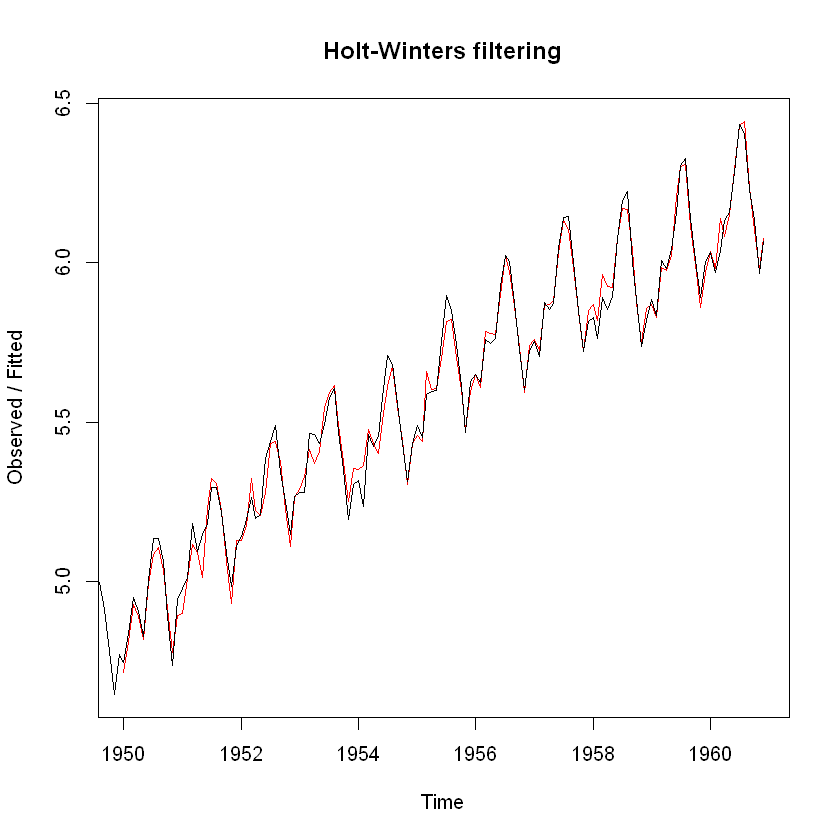

In [47]:
HWAP=stats::HoltWinters(lAirPass,seasonal="additive")   #componente estacional de forma aditiva
plot(HWAP)

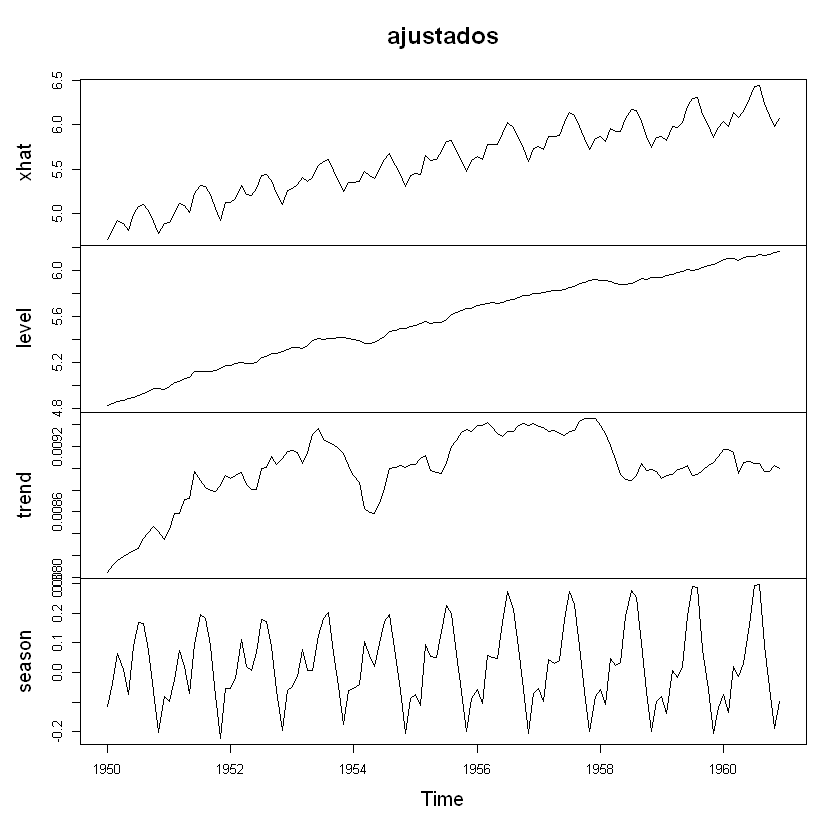

In [48]:
ajustados=fitted(HWAP)
plot(ajustados)

In [46]:
#ajustados
HWAP

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
stats::HoltWinters(x = lAirPass, seasonal = "additive")

Smoothing parameters:
 alpha: 0.3266015
 beta : 0.005744138
 gamma: 0.8206654

Coefficients:
            [,1]
a    6.172308435
b    0.008981893
s1  -0.073201087
s2  -0.140973564
s3  -0.036703294
s4   0.014522733
s5   0.032554237
s6   0.154873570
s7   0.294317062
s8   0.276063997
s9   0.088237657
s10 -0.032657089
s11 -0.198012716
s12 -0.102863837

En la salida anterior se logra evidenciar la estimación de los parámetros *$\alpha$, $\beta$, $\gamma$* y la estimación de los 12 parámetros estacionales con a,b

## Pronósticos

Se quiere pronosticar los siguientes 12 periodos de tiempo, es decir el siguiente año:

Warning message in InvBoxCox(pmean, lambda, biasadj, list(level = level, upper = upper, :
"biasadj information not found, defaulting to FALSE."

         Point Forecast    Lo 95    Hi 95
Jan 1961       449.4790 416.2477 485.3634
Feb 1961       423.8157 390.9003 459.5027
Mar 1961       474.6372 436.0759 516.6085
Apr 1961       504.0920 461.3999 550.7342
May 1961       517.8948 472.3087 567.8808
Jun 1961       590.5613 536.6726 649.8610
Jul 1961       685.0547 620.3955 756.4530
Aug 1961       678.7328 612.5983 752.0071
Sep 1961       567.5808 510.5867 630.9369
Oct 1961       507.4866 455.0505 565.9649
Nov 1961       434.0226 387.9417 485.5771
Dec 1961       481.6546 429.1732 540.5538

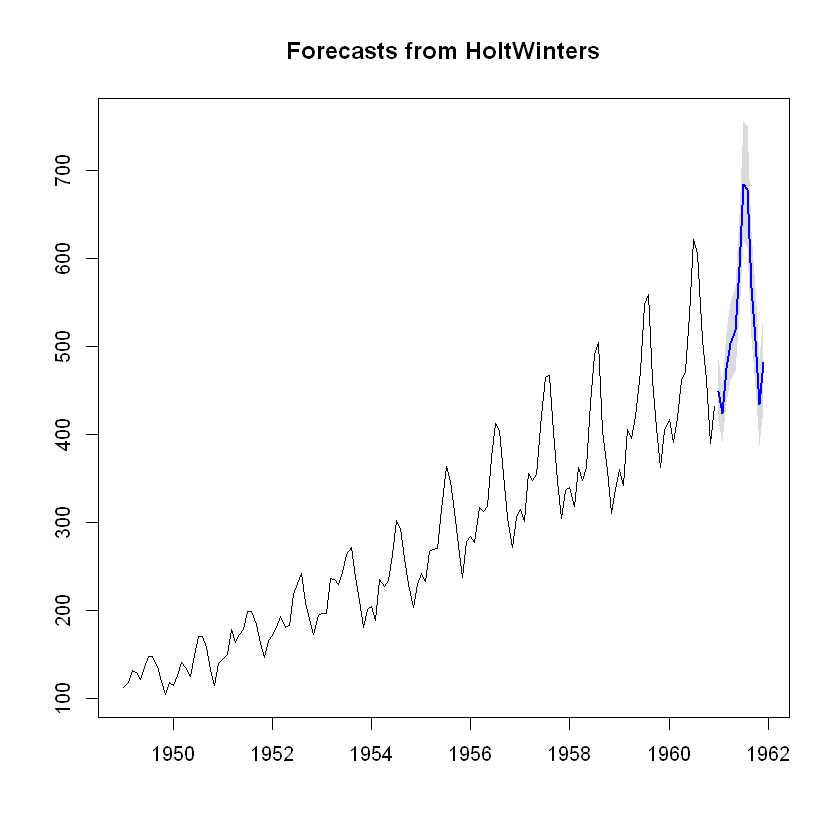

In [52]:
predictionHWAP_1=forecast(HWAP,h=12,level =0.95,lambda = 0)
predictionHWAP_1
plot(predictionHWAP_1)

Otra predicción puede hacerse con la función *predit* del paquete **stats**

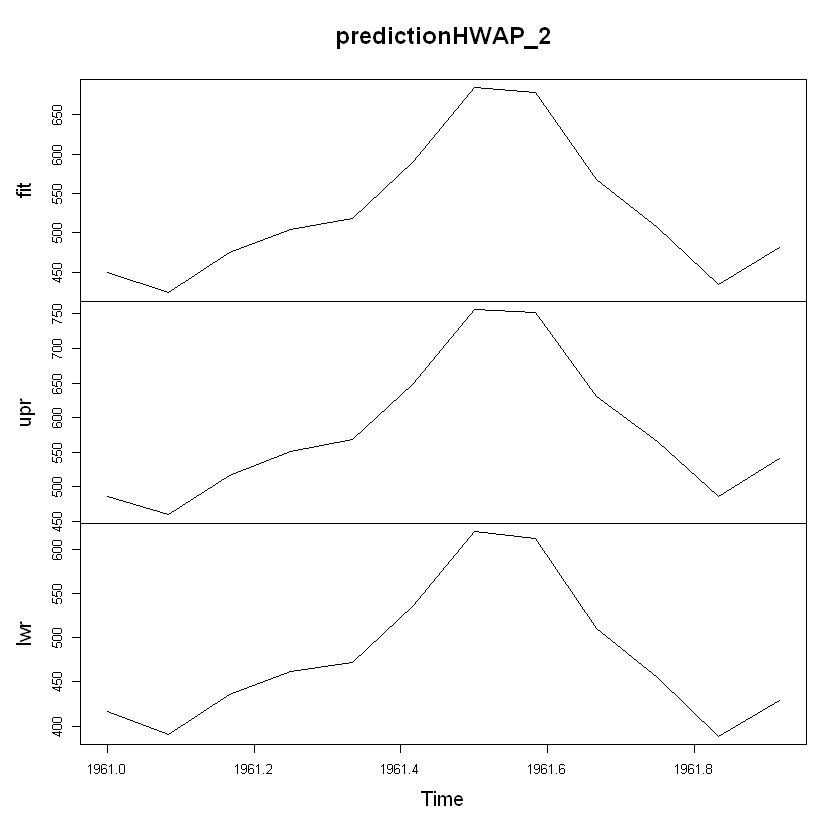

In [55]:
predictionHWAP_2=predict(HWAP,n.ahead = 12, prediction.interval = T, level = 0.95)
predictionHWAP_2=forecast::InvBoxCox(predictionHWAP_2,lambda=0)    #usa la función inversa de boxcox
plot(predictionHWAP_2)